# Naive Risk Budgeting Strategies between the PSP and GHP

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs back test(simulation) of allocating  between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenatios.
    allocator is a function thattakes two sets of the returns and allocatoe specific parametors,
    and produces an allocation to the first portfolio (the rest of the money is invested in the GHP)
    as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be a same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("The weights allocator returned don't match r1")
    r_mix= weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
def fixedmix_allovcator(r1, r2, w1, **kwargs):
    """ 
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
        each column is a scenario
        each row is the price for a time stamp
    Returns an T x N DataFrame of PSP weights
    """
    return pd.DataFrame(data=w1, index = r1.index, columns=r1.columns)

In [4]:
rates , zc_prices =erk.updated_cir(10,500 ,b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, 0.05, 12, rates) # type: ignore
price_30 = erk.bond_price(30, 100, 0.05, 12, rates) # type: ignore
rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)

/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4166666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  coupons.iloc[pay_date] = principal * coupon_rate/coupons_per_year
/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4166666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  coupons.iloc[pay_date] = principal * coupon_rate/coupons_per_year
/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:596: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4166666666666667' has dtype incompat

In [ ]:
rets_bonds=erk.bt_mix(rets_10,rets_30, allocator=erk.fixedmix_allocator, w1=0.6)
mean_rets_bonds = rets_bonds.mean(axis="columns")
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.036422,0.00378,0.515263,4.002473,-0.001385,-0.000895,1.653278,-0.000089


In [10]:
price_eq=erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [13]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allovcator, w1= 0.7)
rets_7030b_mean = rets_7030b.mean(axis="columns")
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.059893,0.004748,0.211064,2.928307,-0.002696,-0.002172,6.127294,0.0


In [14]:
summaries = erk.summary_stats(pd.DataFrame(rets_7030b))

In [15]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.015530,0.110636,0.283426,3.239399,0.047762,0.060192,-0.127420,-0.261108
1,0.031584,0.107859,0.451126,3.053302,0.043803,0.049277,0.014167,-0.140888
2,0.088769,0.112803,0.021640,2.860033,0.045596,0.058964,0.506950,-0.211888
3,-0.013805,0.110370,-0.310235,2.342575,0.056000,0.066103,-0.386392,-0.319799
4,0.001173,0.110766,-0.067075,3.813860,0.051851,0.068942,-0.253421,-0.272608


In [16]:
summaries.mean()

Annualized Return          0.054457
Annualized Vol             0.107178
Skewness                   0.007019
Kurtosis                   3.008515
Cornish-Fisher VaR (5%)    0.045719
Historic CVaR (5%)         0.058094
Sharpe Ratio               0.224892
Max Drawdown              -0.206905
dtype: float64

In [17]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30")
],axis=1)

,FI,Eq,70/30
mean,1.392237,1.974707,1.787254
std,0.105509,0.969710,0.606602
p_breach,NaN,0.044000,0.012000
e_short,NaN,0.161634,0.121007
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


/var/folders/_5/80rp92qj06xby1j6gc1k5r100000gn/T/ipykernel_59731/127787804.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(erk.terminal_values(rets_eq),color='red', label="100% Equities")
/var/folders/_5/80rp92qj06xby1j6gc1k5r100000gn/T/ipykernel_59731/127787804.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

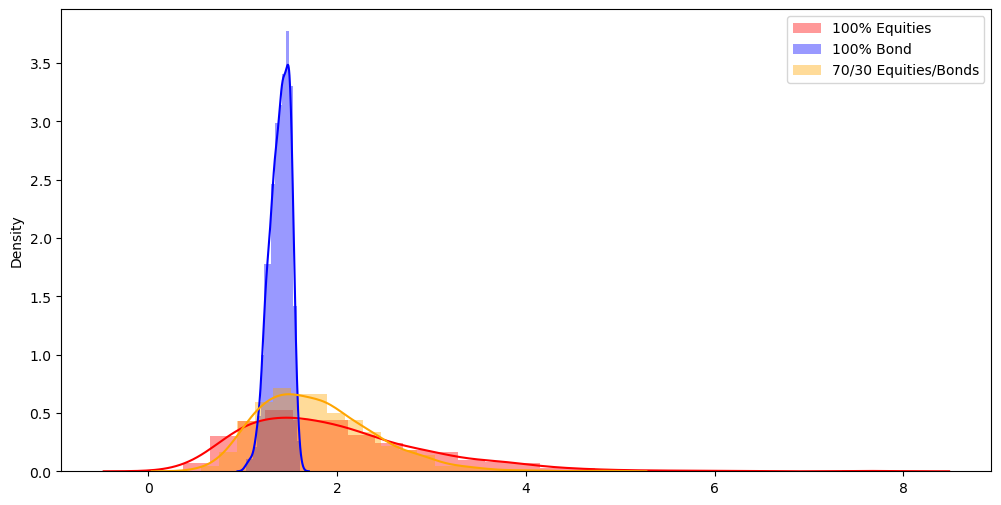

In [22]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq),color='red', label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds),color='blue', label="100% Bond")
sns.distplot(erk.terminal_values(rets_7030b),color='orange', label="70/30 Equities/Bonds")
plt.legend();
plt.show()

## Glide Paths for Allocation

In [24]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    """
    n_points = r1.shape[0]
    n_col=r1.shape[1]
    path=pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col,axis=1)
    paths.index=r1.index
    paths.columns= r1.columns
    return paths

In [25]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=80, end_glide=70)
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="F70/30"),
    erk.terminal_stats(rets_g8020, name="Glide 80 to 20")
],axis=1)

,FI,Eq,F70/30,Glide 80 to 20
mean,1.392237,1.974707,1.787254,5.910820e+48
std,0.105509,0.969710,0.606602,1.372708e+50
p_breach,NaN,0.044000,0.012000,5.080000e-01
e_short,NaN,0.161634,0.121007,4.504608e+47
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
